In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet18, resnet50
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
device = torch.device('cuda:0')

In [4]:
data_dir = '/kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [5]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [6]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
train_size = 0.8

In [7]:
recordings_old = sorted(os.listdir(data_dir))

In [8]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [9]:
len(recordings)

638

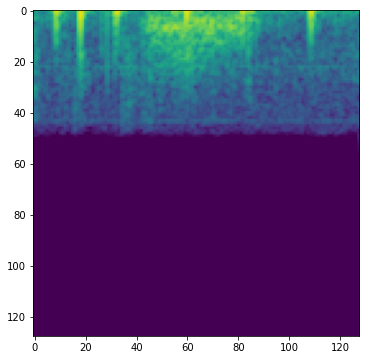

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [11]:
image_size = melspec.shape
image_size

(128, 128)

In [12]:
melspec = torch.tensor(melspec)
melspec = torch.stack([melspec, melspec, melspec])

In [13]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 25):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def TimeCycleShift(image, max_shift = 25):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def TimeSwapAugmentation(image, max_b = 25):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def TimeReplyMasking(image, max_b = 25):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 25):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def SwapSeveralStripes(image, max_n = 4, max_b0 = 25):
    n = np.random.randint(max_n + 1)
    for i in range(n):
        max_b = max_b0 // n
        b = np.random.randint(max_b)
        b1 = np.random.randint(image.shape[2] - b)
        while True:
            b2 = np.random.randint(image.shape[2] - b)
            if np.abs(b1 - b2) >= b:
                t = image[:, :, b1 : b1 + b].clone()
                image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
                image[:, :, b2 : b2 + b] = t
                break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(25)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(25)(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'SwapSeveralStripes':
        return SwapSeveralStripes(image)
    
    return image

In [14]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [15]:
class HeartbeatSounds(Dataset):
    def __init__(self, keys, data = [], labels = []):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
data = []
labels = []
for i in range(len(recordings)):
    if 'normal' in recordings[i]:
        label = 0
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'extrastole' in recordings[i]:
        label = 1
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'murmur' in recordings[i]:
        label = 2
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)

In [17]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, use_augmentation = False, aug_type = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    
    for epoch in tqdm(range(epochs)):
        #Train
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            if use_augmentation:
                for i in range(len(y)):
                    if np.random.rand() < 0.5:
                        X[i] = augmentation(X[i], mode = aug_type)
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)
        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        
        #Validation
        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, [train_losses, valid_losses, valid_acc]

In [18]:
def evaluate(model, test_loader):
    model.eval()
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)

    mean_accuracy = sum_accuracy / cnt_objects
    print('************************')
    print('Quality of the model')
    print('Accuracy on test:', mean_accuracy)
    return mean_accuracy

In [19]:
no_augmentation_accuracy18 = []
time_random_swap_accuracy18 = []
time_swap_augmentation_accuracy18 = []
swap_several_stripes_accuracy18 = []

no_augmentation_accuracy50 = []
time_random_swap_accuracy50 = []
time_swap_augmentation_accuracy50 = []
swap_several_stripes_accuracy50 = []

# Random seed = 1

In [20]:
random_seed = 1

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = HeartbeatSounds(data = data, labels = labels, keys = train_keys)
valid_dataset = HeartbeatSounds(data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 1


100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


Accuracy on the validation:  0.8603174603174604
************************
Quality of the model
Accuracy on test: 0.7791878172588832


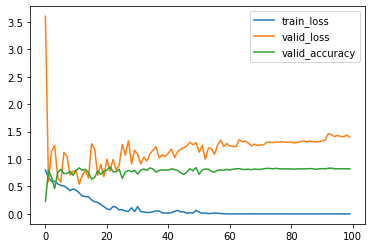

In [21]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 1


100%|██████████| 100/100 [03:14<00:00,  1.94s/it]


Accuracy on the validation:  0.8507936507936508
************************
Quality of the model
Accuracy on test: 0.8071065989847716


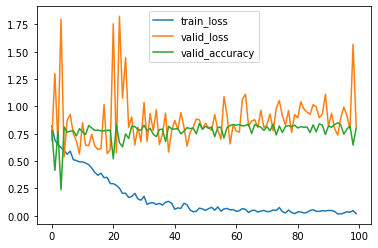

In [22]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 1


100%|██████████| 100/100 [03:15<00:00,  1.95s/it]


Accuracy on the validation:  0.8571428571428571
************************
Quality of the model
Accuracy on test: 0.8401015228426396


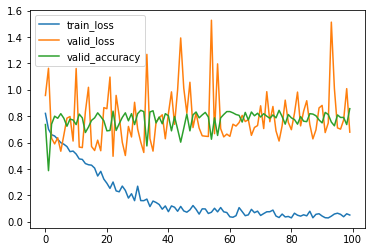

In [23]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### SwapSeveralStripes

setting everything to seed 1


100%|██████████| 100/100 [03:20<00:00,  2.00s/it]


Accuracy on the validation:  0.8634920634920635
************************
Quality of the model
Accuracy on test: 0.8401015228426396


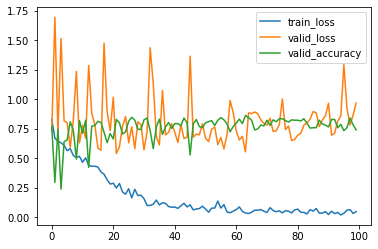

In [24]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'SwapSeveralStripes')

swap_several_stripes_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 1


100%|██████████| 100/100 [06:50<00:00,  4.10s/it]


Accuracy on the validation:  0.8539682539682539
************************
Quality of the model
Accuracy on test: 0.8324873096446701


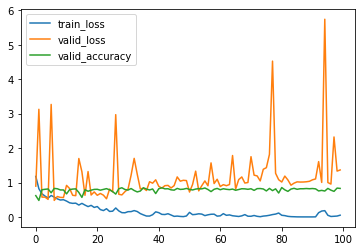

In [25]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 1


100%|██████████| 100/100 [06:57<00:00,  4.18s/it]


Accuracy on the validation:  0.8571428571428571
************************
Quality of the model
Accuracy on test: 0.8375634517766497


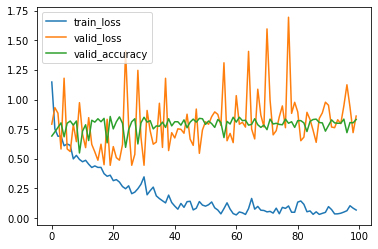

In [26]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 1


100%|██████████| 100/100 [06:58<00:00,  4.19s/it]


Accuracy on the validation:  0.8476190476190476
************************
Quality of the model
Accuracy on test: 0.8426395939086294


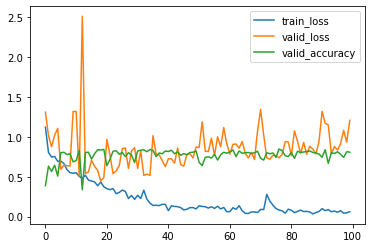

In [27]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### SwapSeveralStripes

setting everything to seed 1


100%|██████████| 100/100 [07:02<00:00,  4.22s/it]


Accuracy on the validation:  0.8539682539682539
************************
Quality of the model
Accuracy on test: 0.8350253807106599


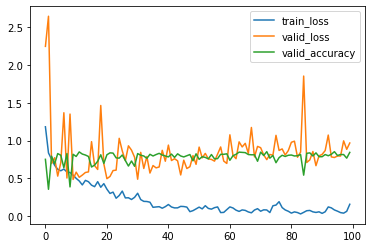

In [28]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'SwapSeveralStripes')

swap_several_stripes_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 42

In [29]:
random_seed = 42

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = HeartbeatSounds(data = data, labels = labels, keys = train_keys)
valid_dataset = HeartbeatSounds(data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 42


100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


Accuracy on the validation:  0.8317460317460318
************************
Quality of the model
Accuracy on test: 0.8324873096446701


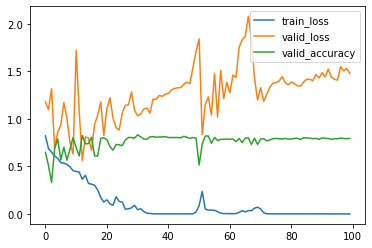

In [30]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 42


100%|██████████| 100/100 [03:14<00:00,  1.95s/it]


Accuracy on the validation:  0.8507936507936508
************************
Quality of the model
Accuracy on test: 0.8121827411167513


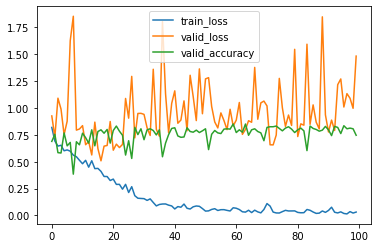

In [31]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 42


100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


Accuracy on the validation:  0.8507936507936508
************************
Quality of the model
Accuracy on test: 0.8477157360406091


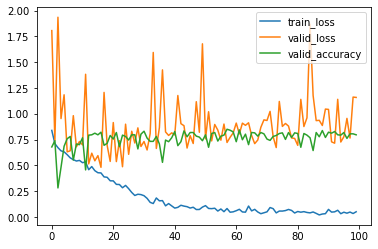

In [32]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### SwapSeveralStripes

setting everything to seed 42


100%|██████████| 100/100 [03:20<00:00,  2.00s/it]


Accuracy on the validation:  0.8253968253968254
************************
Quality of the model
Accuracy on test: 0.8401015228426396


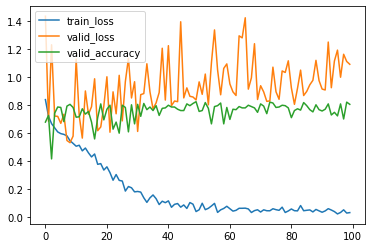

In [33]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'SwapSeveralStripes')

swap_several_stripes_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 42


100%|██████████| 100/100 [06:50<00:00,  4.10s/it]


Accuracy on the validation:  0.8444444444444444
************************
Quality of the model
Accuracy on test: 0.8223350253807107


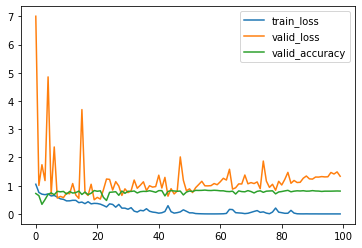

In [34]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 42


100%|██████████| 100/100 [06:58<00:00,  4.19s/it]


Accuracy on the validation:  0.8380952380952381
************************
Quality of the model
Accuracy on test: 0.8071065989847716


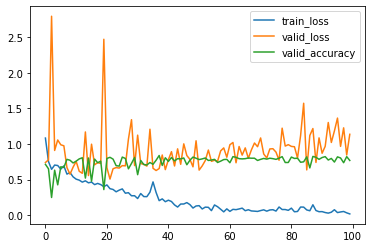

In [35]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 42


100%|██████████| 100/100 [06:58<00:00,  4.19s/it]


Accuracy on the validation:  0.8571428571428571
************************
Quality of the model
Accuracy on test: 0.8223350253807107


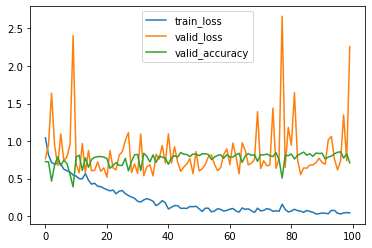

In [36]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### SwapSeveralStripes

setting everything to seed 42


100%|██████████| 100/100 [07:02<00:00,  4.23s/it]


Accuracy on the validation:  0.834920634920635
************************
Quality of the model
Accuracy on test: 0.8248730964467005


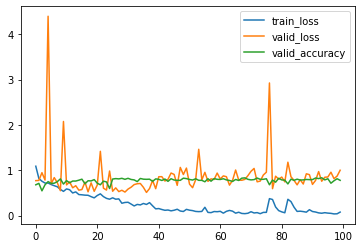

In [37]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'SwapSeveralStripes')

swap_several_stripes_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 10

In [38]:
random_seed = 10

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = HeartbeatSounds(data = data, labels = labels, keys = train_keys)
valid_dataset = HeartbeatSounds(data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 10


100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


Accuracy on the validation:  0.8095238095238095
************************
Quality of the model
Accuracy on test: 0.817258883248731


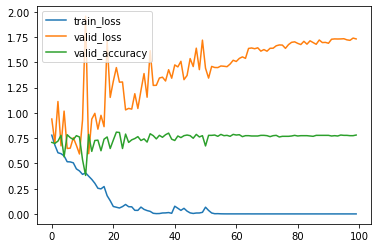

In [39]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 10


100%|██████████| 100/100 [03:17<00:00,  1.98s/it]


Accuracy on the validation:  0.8380952380952381
************************
Quality of the model
Accuracy on test: 0.8147208121827412


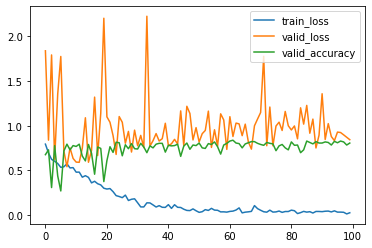

In [40]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 10


100%|██████████| 100/100 [03:18<00:00,  1.99s/it]


Accuracy on the validation:  0.8476190476190476
************************
Quality of the model
Accuracy on test: 0.8350253807106599


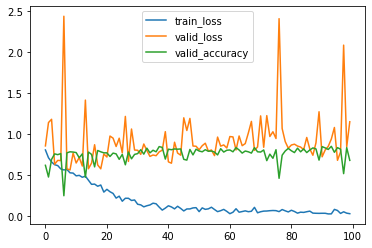

In [41]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### SwapSeveralStripes

setting everything to seed 10


100%|██████████| 100/100 [03:21<00:00,  2.01s/it]


Accuracy on the validation:  0.8285714285714286
************************
Quality of the model
Accuracy on test: 0.8324873096446701


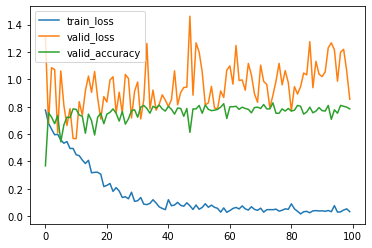

In [42]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'SwapSeveralStripes')

swap_several_stripes_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 10


100%|██████████| 100/100 [06:51<00:00,  4.12s/it]


Accuracy on the validation:  0.8317460317460318
************************
Quality of the model
Accuracy on test: 0.7842639593908629


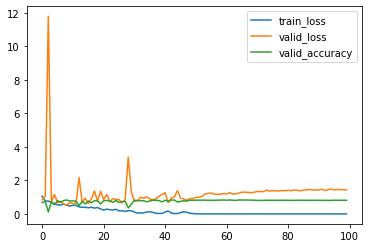

In [43]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 10


100%|██████████| 100/100 [06:57<00:00,  4.18s/it]


Accuracy on the validation:  0.8412698412698413
************************
Quality of the model
Accuracy on test: 0.8426395939086294


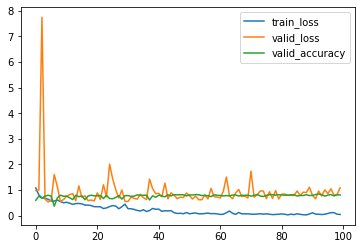

In [44]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 10


100%|██████████| 100/100 [06:58<00:00,  4.18s/it]


Accuracy on the validation:  0.8539682539682539
************************
Quality of the model
Accuracy on test: 0.8451776649746193


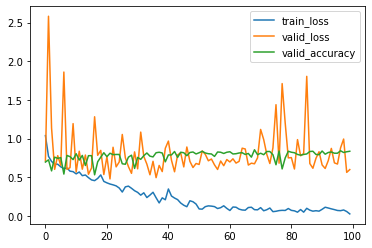

In [45]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### SwapSeveralStripes

setting everything to seed 10


100%|██████████| 100/100 [07:02<00:00,  4.23s/it]


Accuracy on the validation:  0.8380952380952381
************************
Quality of the model
Accuracy on test: 0.8274111675126904


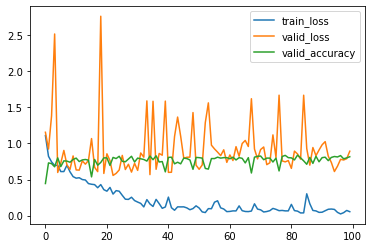

In [46]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'SwapSeveralStripes')

swap_several_stripes_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 15

In [47]:
random_seed = 15

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = HeartbeatSounds(data = data, labels = labels, keys = train_keys)
valid_dataset = HeartbeatSounds(data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 15


100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


Accuracy on the validation:  0.8444444444444444
************************
Quality of the model
Accuracy on test: 0.850253807106599


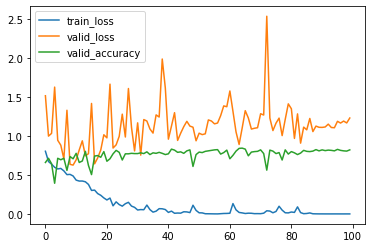

In [48]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 15


100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


Accuracy on the validation:  0.834920634920635
************************
Quality of the model
Accuracy on test: 0.8274111675126904


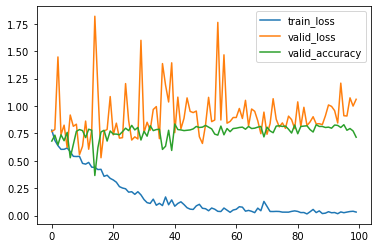

In [49]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 15


100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Accuracy on the validation:  0.8285714285714286
************************
Quality of the model
Accuracy on test: 0.8096446700507615


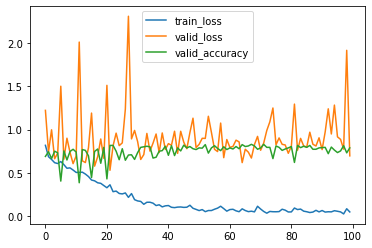

In [50]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### SwapSeveralStripes

setting everything to seed 15


100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


Accuracy on the validation:  0.8412698412698413
************************
Quality of the model
Accuracy on test: 0.8375634517766497


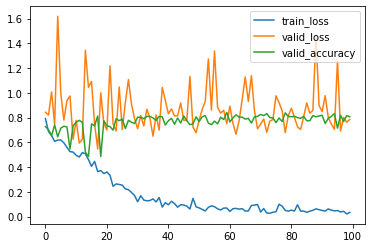

In [51]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'SwapSeveralStripes')

swap_several_stripes_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 15


100%|██████████| 100/100 [06:50<00:00,  4.11s/it]


Accuracy on the validation:  0.8253968253968254
************************
Quality of the model
Accuracy on test: 0.8578680203045685


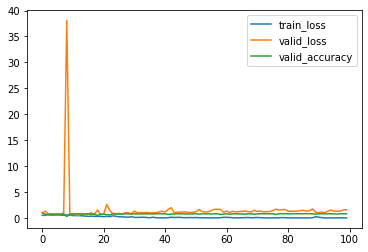

In [52]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 15


100%|██████████| 100/100 [06:57<00:00,  4.18s/it]


Accuracy on the validation:  0.8380952380952381
************************
Quality of the model
Accuracy on test: 0.8248730964467005


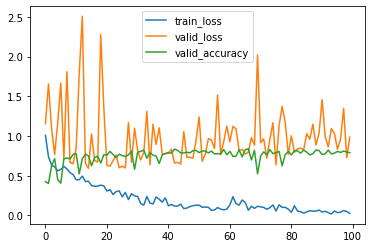

In [53]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 15


100%|██████████| 100/100 [06:58<00:00,  4.19s/it]


Accuracy on the validation:  0.8476190476190476
************************
Quality of the model
Accuracy on test: 0.8477157360406091


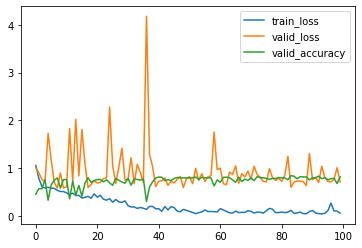

In [54]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### SwapSeveralStripes

setting everything to seed 15


100%|██████████| 100/100 [07:04<00:00,  4.25s/it]


Accuracy on the validation:  0.8412698412698413
************************
Quality of the model
Accuracy on test: 0.8730964467005076


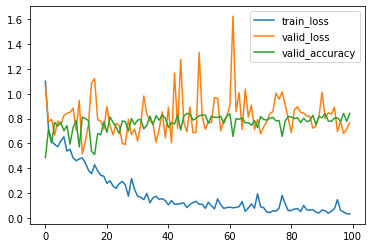

In [55]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'SwapSeveralStripes')

swap_several_stripes_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 23

In [56]:
random_seed = 23

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = HeartbeatSounds(data = data, labels = labels, keys = train_keys)
valid_dataset = HeartbeatSounds(data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(data = data, labels = labels, keys = test_keys)

## Resnet18

#### No augmentation

setting everything to seed 23


100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


Accuracy on the validation:  0.8539682539682539
************************
Quality of the model
Accuracy on test: 0.8197969543147208


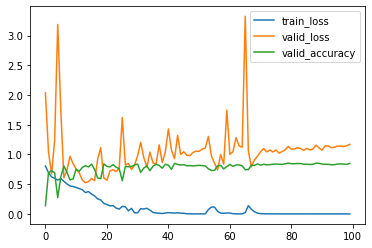

In [57]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 23


100%|██████████| 100/100 [03:18<00:00,  1.99s/it]


Accuracy on the validation:  0.8666666666666667
************************
Quality of the model
Accuracy on test: 0.8197969543147208


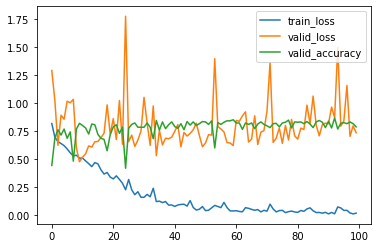

In [58]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 23


100%|██████████| 100/100 [03:19<00:00,  2.00s/it]


Accuracy on the validation:  0.8571428571428571
************************
Quality of the model
Accuracy on test: 0.8274111675126904


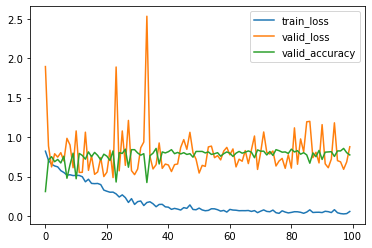

In [59]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### SwapSeveralStripes

setting everything to seed 23


100%|██████████| 100/100 [03:24<00:00,  2.04s/it]


Accuracy on the validation:  0.8476190476190476
************************
Quality of the model
Accuracy on test: 0.8274111675126904


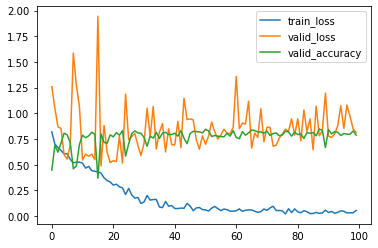

In [60]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'SwapSeveralStripes')

swap_several_stripes_accuracy18.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet50

#### No augmentation

setting everything to seed 23


100%|██████████| 100/100 [06:56<00:00,  4.17s/it]


Accuracy on the validation:  0.8444444444444444
************************
Quality of the model
Accuracy on test: 0.8147208121827412


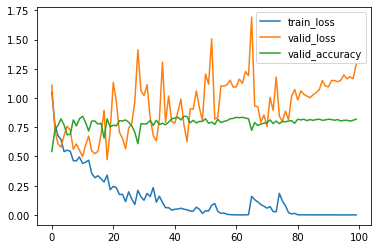

In [61]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

no_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeSwapAugmentation

setting everything to seed 23


100%|██████████| 100/100 [07:01<00:00,  4.22s/it]


Accuracy on the validation:  0.8571428571428571
************************
Quality of the model
Accuracy on test: 0.8578680203045685


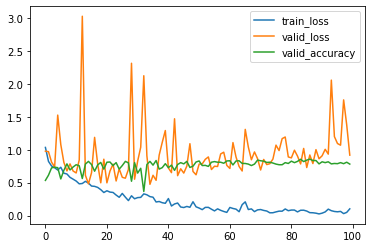

In [62]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeSwapAugmentation')

time_swap_augmentation_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### TimeRandomSwap

setting everything to seed 23


100%|██████████| 100/100 [06:59<00:00,  4.19s/it]


Accuracy on the validation:  0.834920634920635
************************
Quality of the model
Accuracy on test: 0.8248730964467005


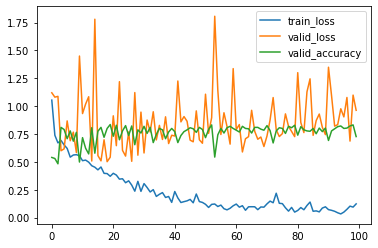

In [63]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'TimeRandomSwap')

time_random_swap_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### SwapSeveralStripes

setting everything to seed 23


100%|██████████| 100/100 [07:03<00:00,  4.24s/it]


Accuracy on the validation:  0.8603174603174604
************************
Quality of the model
Accuracy on test: 0.8604060913705583


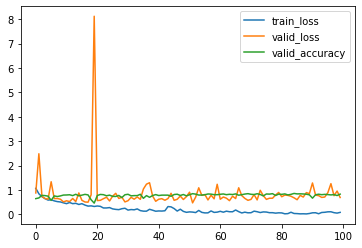

In [64]:
seed_everything(random_seed)

g1 = torch.Generator()
g1.manual_seed(random_seed)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn, generator=g1)
g2 = torch.Generator()
g2.manual_seed(random_seed)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g2)
g3 = torch.Generator()
g3.manual_seed(random_seed)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn, generator=g3)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, use_augmentation = True, aug_type = 'SwapSeveralStripes')

swap_several_stripes_accuracy50.append(evaluate(model, test_dataloader))

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Results

In [65]:
print("resnet18")
no_augmentation_accuracy18 = np.array(no_augmentation_accuracy18) * 100
time_random_swap_accuracy18 = np.array(time_random_swap_accuracy18) * 100
time_swap_augmentation_accuracy18 = np.array(time_swap_augmentation_accuracy18) * 100
swap_several_stripes_accuracy18 = np.array(swap_several_stripes_accuracy18) * 100
print("No augmentation")
print("mean:", np.mean(no_augmentation_accuracy18))
print("std:", np.std(no_augmentation_accuracy18))
print("TimeSwapAugmentation")
print("mean:", np.mean(time_swap_augmentation_accuracy18))
print("std:", np.std(time_swap_augmentation_accuracy18))
print("TimeRandomSwap")
print("mean:", np.mean(time_random_swap_accuracy18))
print("std:", np.std(time_random_swap_accuracy18))
print("SwapSeveralStripes")
print("mean:", np.mean(swap_several_stripes_accuracy18))
print("std:", np.std(swap_several_stripes_accuracy18))

resnet18
No augmentation
mean: 81.9796954314721
std: 2.3427372099927593
TimeSwapAugmentation
mean: 81.6243654822335
std: 0.6922934871566403
TimeRandomSwap
mean: 83.19796954314721
std: 1.2981433352836989
SwapSeveralStripes
mean: 83.55329949238579
std: 0.49215023933160895


In [66]:
print("resnet50")
no_augmentation_accuracy50 = np.array(no_augmentation_accuracy50) * 100
time_random_swap_accuracy50 = np.array(time_random_swap_accuracy50) * 100
time_swap_augmentation_accuracy50 = np.array(time_swap_augmentation_accuracy50) * 100
swap_several_stripes_accuracy50 = np.array(swap_several_stripes_accuracy50) * 100
print("No augmentation")
print("mean:", np.mean(no_augmentation_accuracy50))
print("std:", np.std(no_augmentation_accuracy50))
print("TimeSwapAugmentation")
print("mean:", np.mean(time_swap_augmentation_accuracy50))
print("std:", np.std(time_swap_augmentation_accuracy50))
print("TimeRandomSwap")
print("mean:", np.mean(time_random_swap_accuracy50))
print("std:", np.std(time_random_swap_accuracy50))
print("SwapSeveralStripes")
print("mean:", np.mean(swap_several_stripes_accuracy50))
print("std:", np.std(swap_several_stripes_accuracy50))

resnet50
No augmentation
mean: 82.23350253807106
std: 2.39710029504926
TimeSwapAugmentation
mean: 83.40101522842639
std: 1.7108933549596654
TimeRandomSwap
mean: 83.65482233502539
std: 1.0720158417229906
SwapSeveralStripes
mean: 84.41624365482232
std: 1.9168738668527119
